<div style="background-color:#9FD4E5; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:#000000">Importing Libraries</a>
</h2>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from imblearn.over_sampling import SMOTE

from tabulate import tabulate

<div style="background-color:#9FD4E5; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:#000000">Definition of Functions</a>
</h2>
</div>

In [2]:
# Data visualization functions
def set_style(ax, left=True, bottom=False, axis_grid="y"):
    sns.despine(ax=ax, left=left, bottom=bottom)
    ax.grid(axis=axis_grid, linewidth=0.2, color="black")

def kde(data, column, ax, color=None, meanline_color=None, hue=None, hue_colors=None, title=None):

    sns.kdeplot(data=data, x=column, ax=ax,
        fill=True, linewidth=2, color=color, hue=hue, palette=hue_colors)
    
    if not hue:
        ax.axvline(np.mean(data[column]), linestyle='--', color=meanline_color, linewidth=2)
    else:
        for i, value in enumerate(data[hue].unique()):
            ax.axvline(np.mean(data[data[hue] == value][column]), linestyle='--', linewidth=2, label=value, 
                       color=hue_colors[value])

    ax.set_ylabel("")

    set_style(ax)

def count_values(data, col, ax, color=None):
    data = data[col].value_counts()

    data.index = data.index.map(str)

    ax.bar(x=data.index, height=data.values, 
        linewidth=2, edgecolor='black', color=color, alpha=1)

    labels = [f"{value} | {round(value / sum(data.values) * 100, 1)}%" for value in data.values]
    for container in ax.containers:
        ax.bar_label(container, labels=labels, padding=3, fontsize=15)

    ax.tick_params(axis='y', 
        left=False,  
        right=False, 
        labelleft=False
        )

    ax.set_title(f"Value counts of \"'{col}\" column", fontsize="xx-large")

    set_style(ax)

def scatter(data, x, y, ax, hue=None, hue_colors=None, color=None):

    sns.scatterplot(data=data, x=x, y=y, ax=ax, hue=hue, 
        palette=hue_colors, linewidth=1, edgecolor='black', alpha=0.7)
    
    ax.set_xlabel(x, fontsize="xx-large")
    ax.set_ylabel(y, fontsize="xx-large")

    set_style(ax)

def correlation_matrix(data, ax, subset=None, palette=None):

    if not subset:
        subset = data.columns

    corr = data[subset].corr()


    sns.heatmap(corr, annot=True, ax=ax,
                cmap=palette, square=True, linewidth=.5, linecolor="black",
                vmin=-1, vmax=1, fmt=".2f")


    ax.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,
        left=False,
        right=False
        )

# Modelling functions
def classifier_evaluation(y_true, y_predict, y_scores, label="Test"):

    accuracy = accuracy_score(y_true, y_predict)
    precision = precision_score(y_true, y_predict)
    recall  = recall_score(y_true, y_predict)
    f1 = f1_score(y_true, y_predict)
    auc = roc_auc_score(y_true, y_scores)

    header = ["Accuracy", "Precision", "Recall", "F1 Score", "Auc Score"]
    
    data = [accuracy, precision, recall, f1, auc]
    data = [round(el, 2) for el in data]

    table = [header, data]

    if label:
        print(f"{label} scores")

    print(tabulate(table, headers="firstrow", tablefmt="rst"))

def cv_and_evaluate(model, X_train, y_train, X_test, y_test, name=None):

    cv_score = cross_val_score(model, X_train, y_train, cv=4, n_jobs=-1)
    
    print(f"{name} CV Results \t Mean: {np.mean(cv_score)} \t Std: {np.std(cv_score)}")
    print(cv_score)

    model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test)
    
    try:
        y_test_score = model.predict_proba(X_test)[:, 1]
    except:
        y_test_score = model.decision_function(X_test)

    classifier_evaluation(y_test, y_test_pred, y_test_score)


In [3]:
color = "#4084DD"
hue_dict = {
    0: "#7A9E7E",
    1: "#BA3B54"
}

<div>
<div style="float:left; width:50%; background-color:#7A9E7E; height:50px"></div>
<div style="float:left; width:50%; background-color:#BA3B54; height:50px"></div>
</div>

<p style="font-size:1.2em; text-align:center">Green : Non-diabetic Patients (0) <br> Red : Diabetic Patients (1)</p>

<div style="background-color:#9FD4E5; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:#000000">Import Dataset</a>
</h2>
</div>

In [4]:
df = pd.read_csv("diabetes.csv")

print(f"Shape of dataset -> {df.shape}")
df.head()

Shape of dataset -> (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<p style="font-size:1.2em">From the analysis above, we can see that:</p>
<ol style="font-size:1.2em">
    <li>The dataset has 768 instances and 9 columns. Our target result is the <i>"Outcome"</i> and the other 8 are features that will help us predict the outcome. </li>
    <li>The data are all of numeric type. It appears that there are no missing values, but this is not a guarantee because they could be replaced with a neutral value.</li>
    <li>We confirm the suspicion expressed in step 2 by observing the description table: <u>many columns have 0 as the minimum value</u>, and it is impossible to have null as the value for the data provided. In fact, no living person can have zero insulin or blood pressure at 0, and neither can their BMI. Therefore, we will have to replace these values with some more appropriate ones.</li>
    <li>Finally, we note that the data are on different scales: <u>if we use linear models we will have to scale them</u>.</li>
</ol>


<div style="background-color:#9FD4E5; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:#000000">Data Cleaning</a>
</h2>
</div>

<p style="font-size:1.2em">In this phase, the aim is to replace the instances with null values (0) in the selected columns with random values generated within a range around the mean of each column. This approach allowed us to impute missing data while trying to preserve the distribution characteristics of the original data.<br><br>
The following code replaces missing values in selected columns with random values centered around the column mean. These random values are constrained within a range from the mean minus 1.2 times the standard deviation to the mean plus 1.2 times the standard deviation. This approach ensures that the imputed values vary around the mean, preventing the introduction of uniform values for all missing data points.<br><br>
This will allow us to to maintain the distribution characteristics of the original dataset, avoiding any undue influence on the overall shape of the data distribution during the imputation process.</p>


In [7]:
for col in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]:
    mean = df[df[col] != 0][col].mean()
    std = df[df[col] != 0][col].std()

    values = df[col].values

    np.random.seed(23)

    for i, val in enumerate(values):
        if val == 0:
            values[i] = mean + std * (np.random.rand() * 2 - 1) * 1.2
    df[col] = pd.Series(values).astype(df[col].dtype)

In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.705729,72.371094,28.907552,152.865885,32.446890,0.471876,33.240885,0.348958
std,3.369578,30.481394,12.249431,9.632385,102.668104,6.896638,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,13.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,22.000000,77.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,134.500000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,205.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<div style="background-color:#00FFFF; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:blue">EDA</a></h2>
</div>

<div style="background-color:#9FD4E5; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:#000000">Distribution of Data</a>
</h2>
</div>

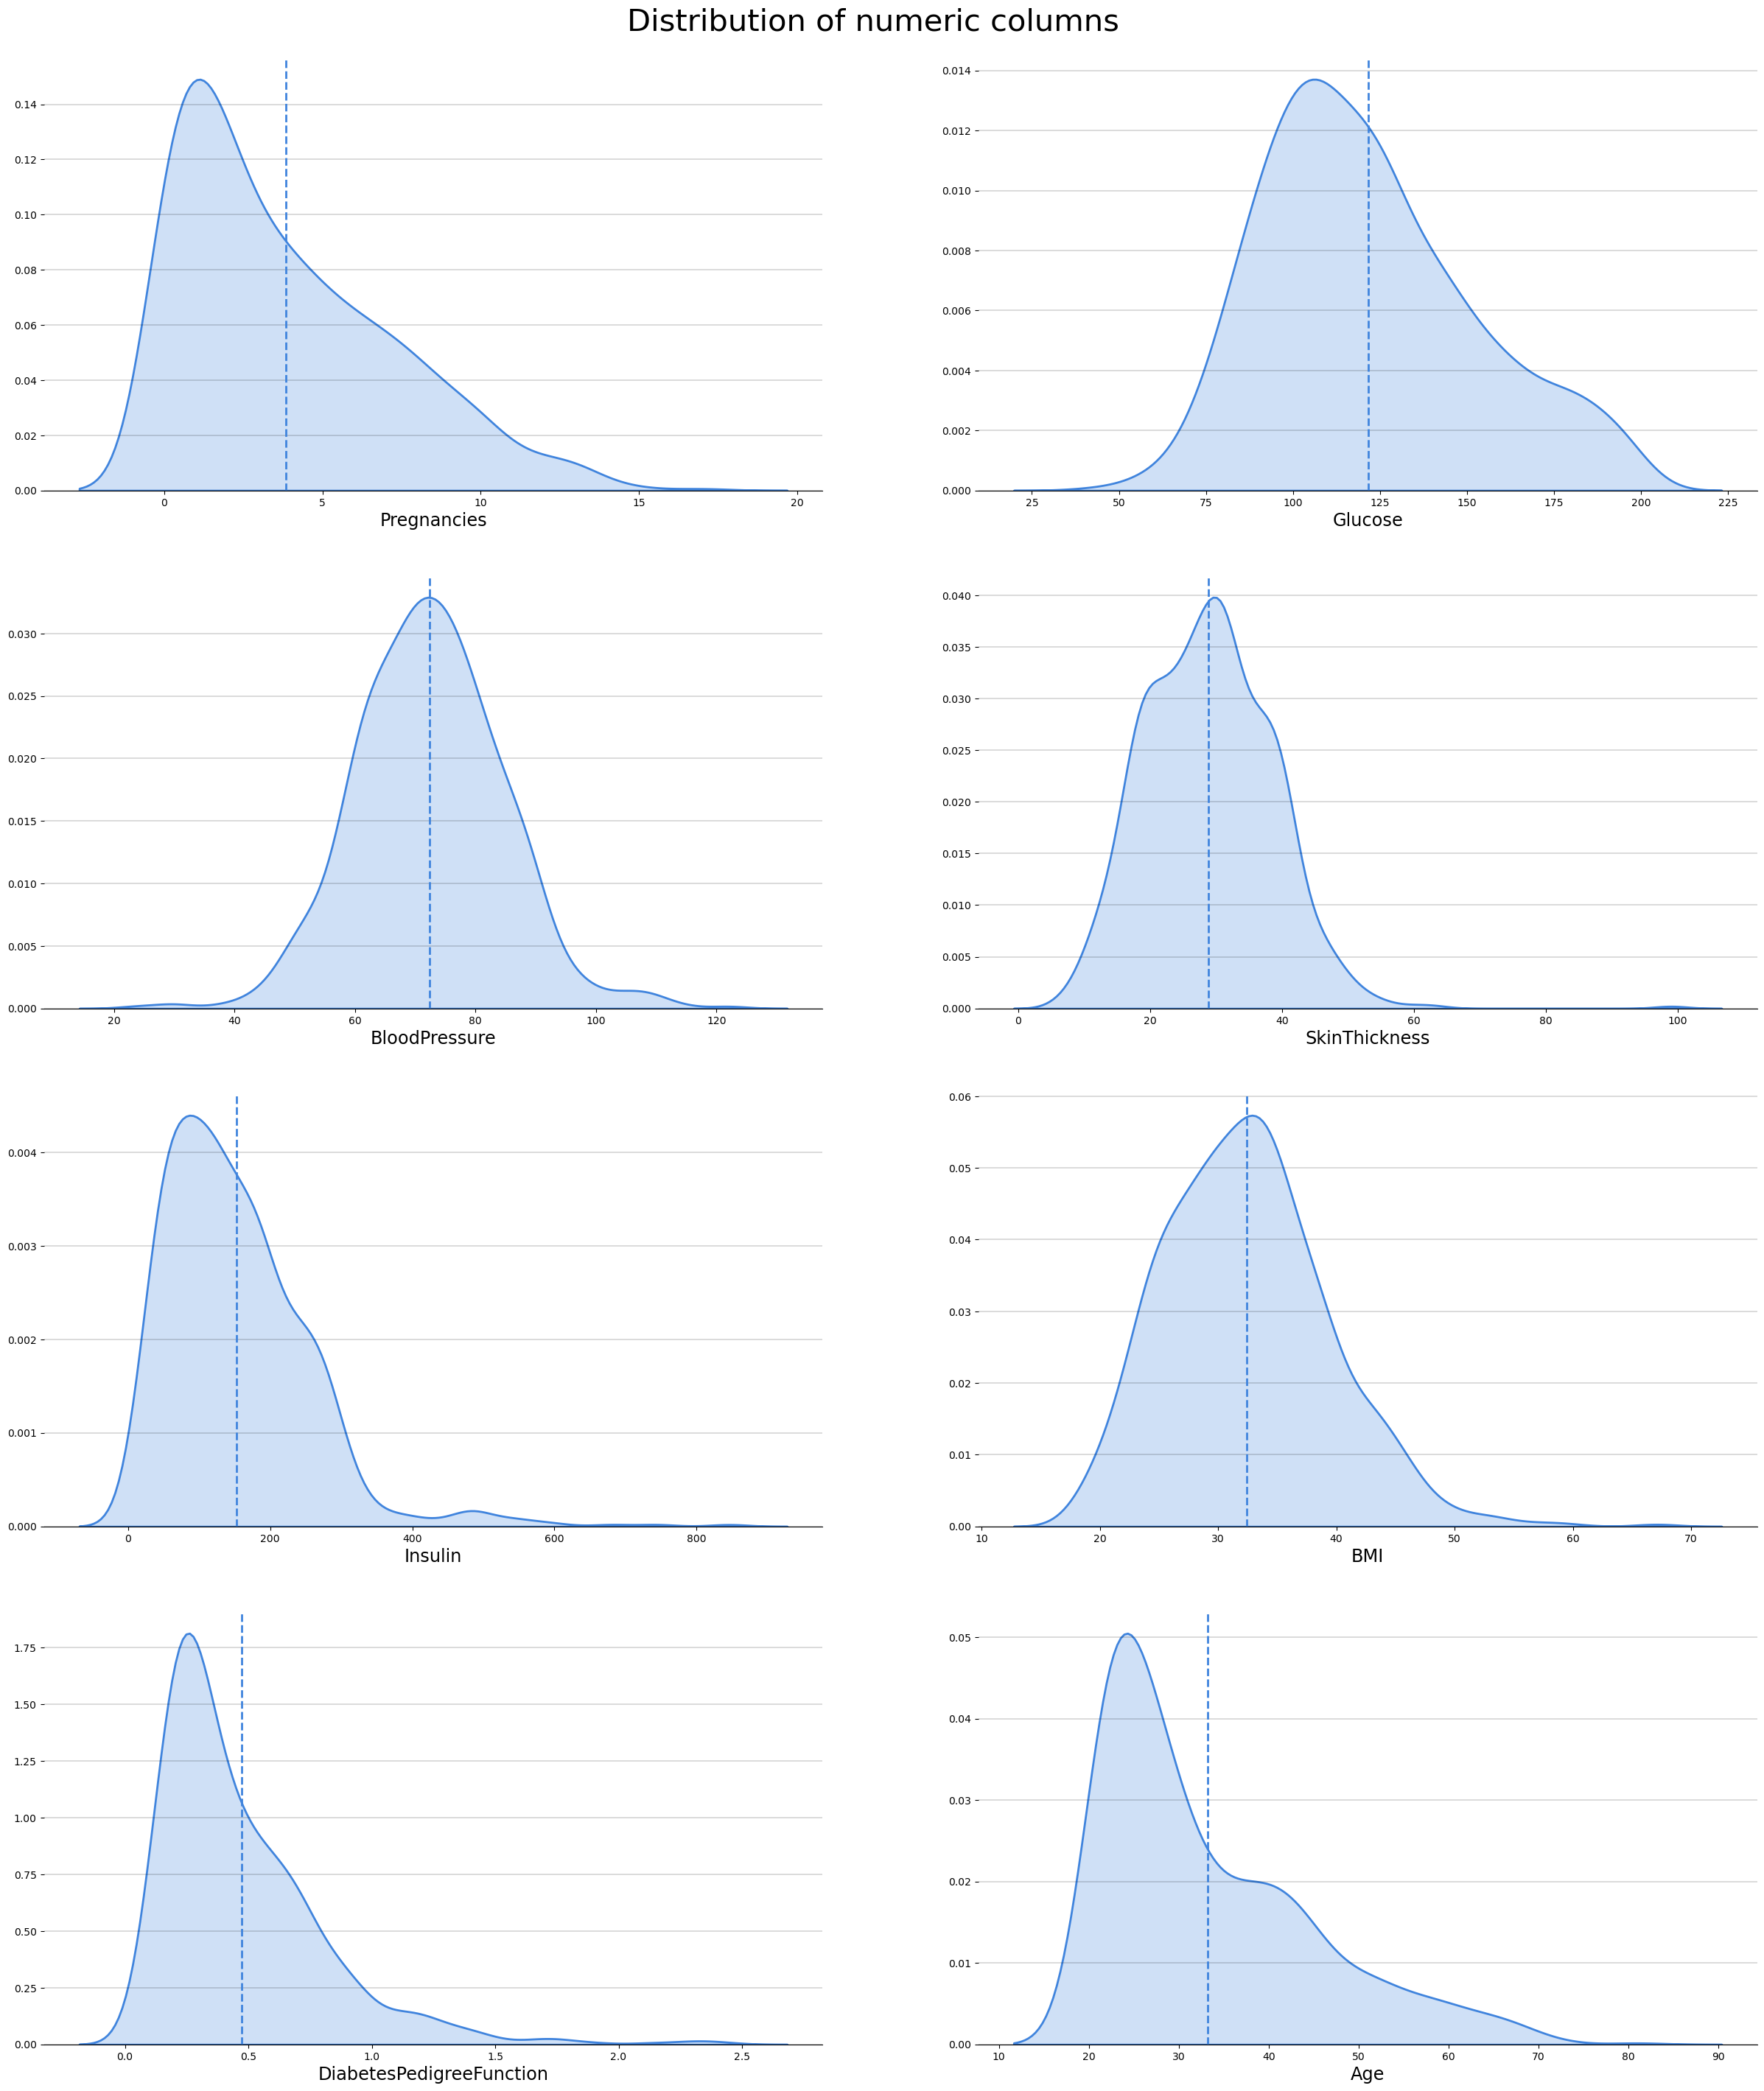

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

for i, col in enumerate(df.columns.drop("Outcome")):
    ax = axs[i // 2][i % 2]

    kde(df, col, ax, color=color, meanline_color=color)
    ax.set_xlabel(col, fontsize="xx-large")

fig.suptitle("Distribution of numeric columns", fontsize=30, y=0.90)

plt.show()

<p style="font-size:1.2em">From that graph, we can see:</p>

<ol style="font-size:1.2em">
    <li>"Pregnancies", "Insulin", "DiabetesPedigreeFunction" and "Age" have a right-skewed distribution.</li>
    <li>In contrast, "Glucose," "BloodPressure," "SkinThickness" and "BMI" have a normal distribution.</li>
    <li>We can see that the ages of our patients ranged from just over 10 to even 90 years old, showing a very high range of age.</li>
    
    
</ol>

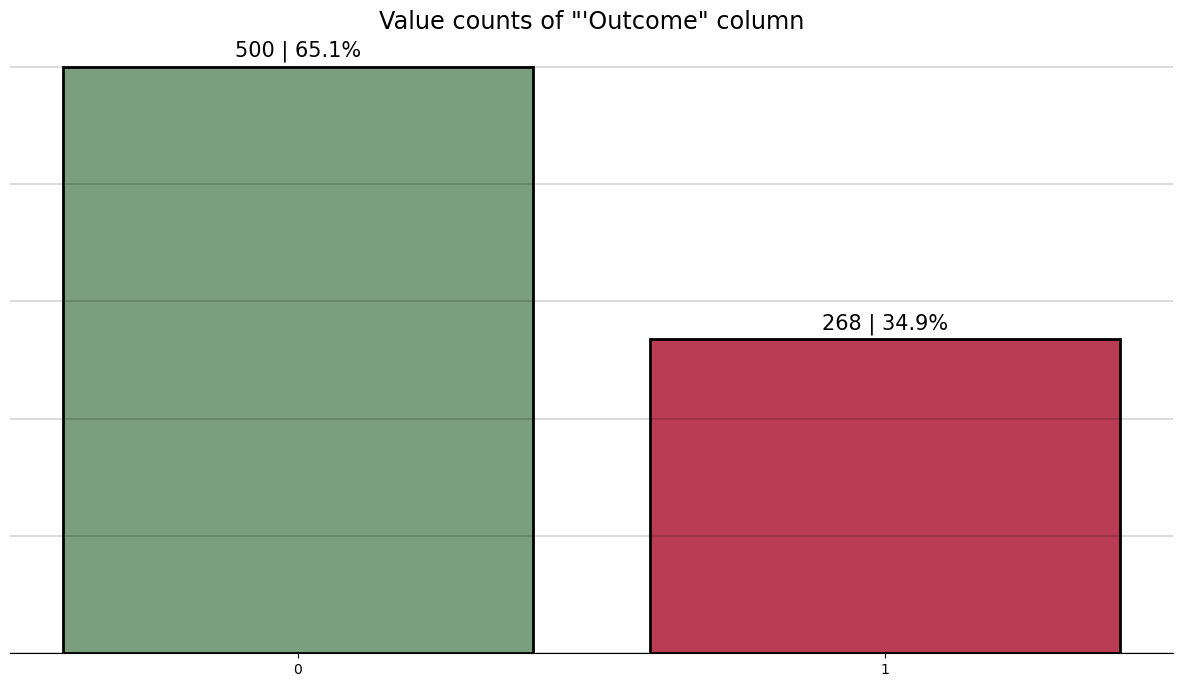

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

count_values(df, "Outcome", ax, color=hue_dict.values())

plt.show()

<p style="font-size:1.2em">The target distribution, as is often the case in medical cases, is skewed toward negative cases. But this is not an extreme imbalance, as positive cases are about 35 percent</p>

<div style="background-color:#9FD4E5; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:#000000">Distribution of features by Outcome</a>
</h2>
</div>

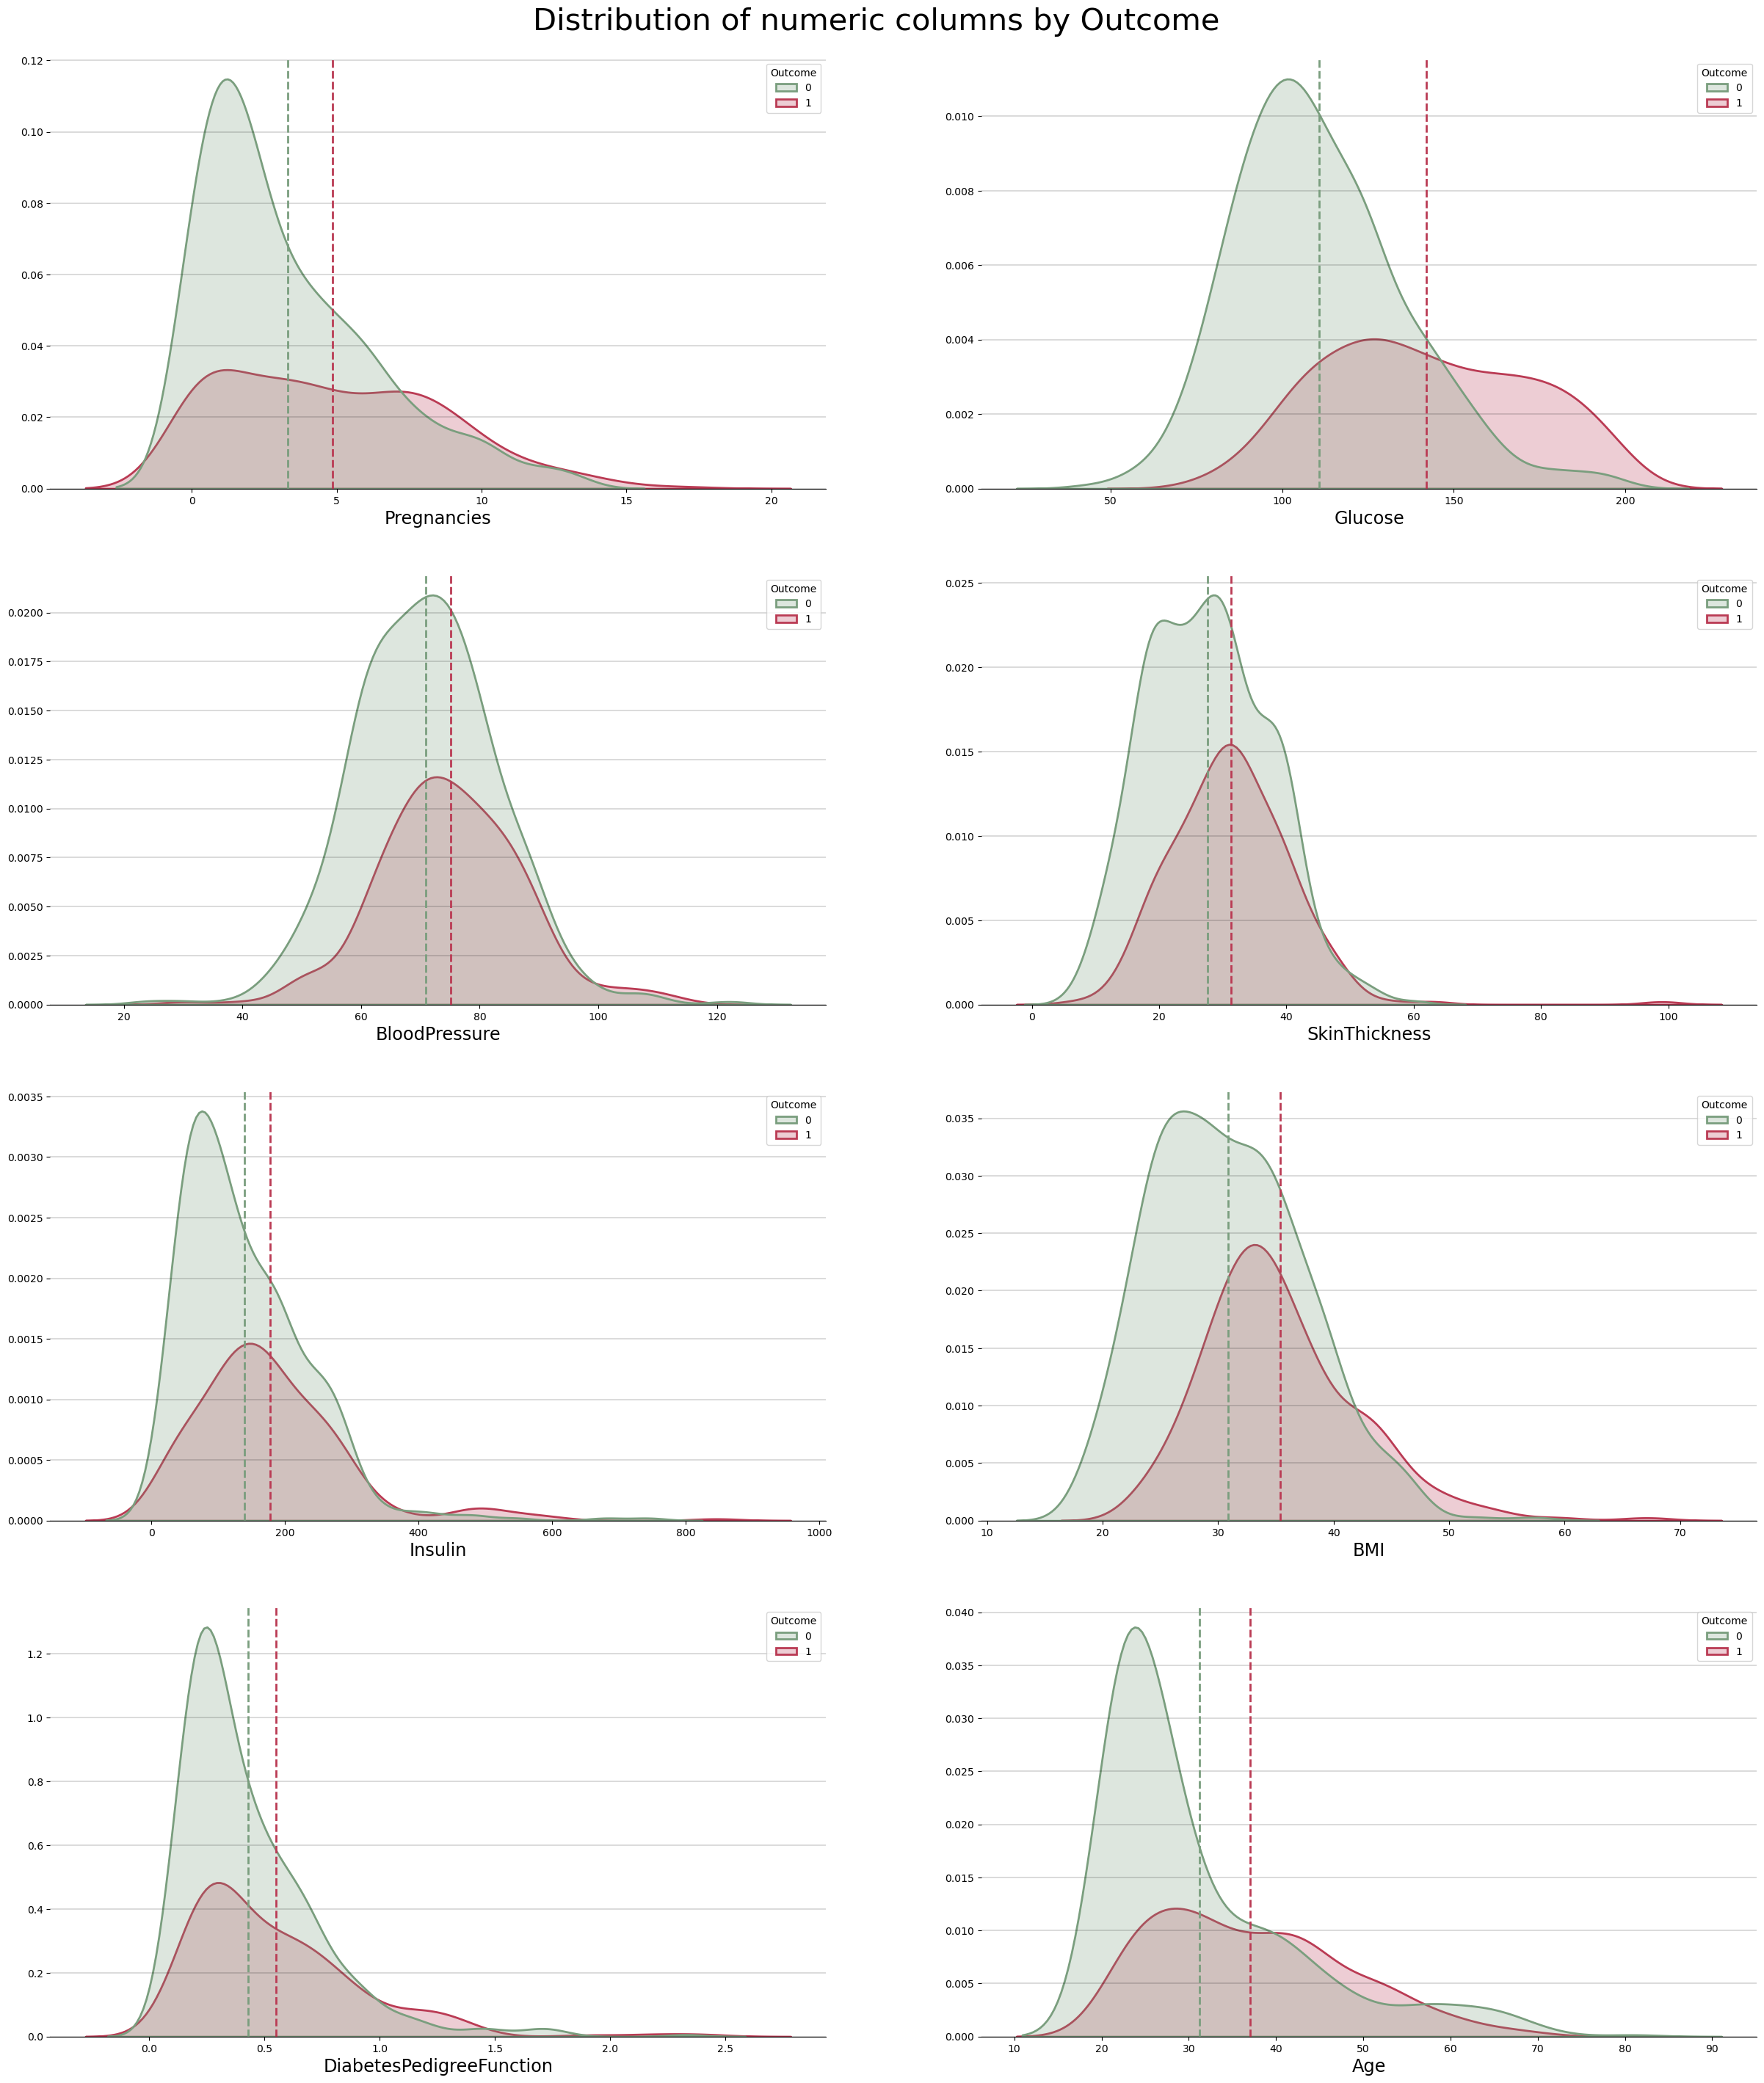

In [11]:
fig, axs = plt.subplots(4, 2, figsize=(30, 35))

for i, col in enumerate(df.columns.drop("Outcome")):
    ax = axs[i // 2][i % 2]

    kde(df, col, ax, hue="Outcome", hue_colors=hue_dict)
    ax.set_xlabel(col, fontsize="xx-large")

fig.suptitle("Distribution of numeric columns by Outcome", fontsize=30, y=0.90)

plt.show()

<p style="font-size:1.2em">From the graph, patients that are diagnosed with diabetes tend to have higher values for all available features. <br> This is especially true for "Glucose" and "BMI," where both the distribution and the mean of the two classes differ the most.</p>

<p style="font-size:1.2em">In terms of age, the difference between the mean of the two classes is also very large. <br><br>It is also interesting to note that having more pregnancies correlates with a higher likelihood of being diagnosed with diabetes.</p>

<div style="background-color:#9FD4E5; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:#000000">Correlation between variables</a>
</h2>
</div>

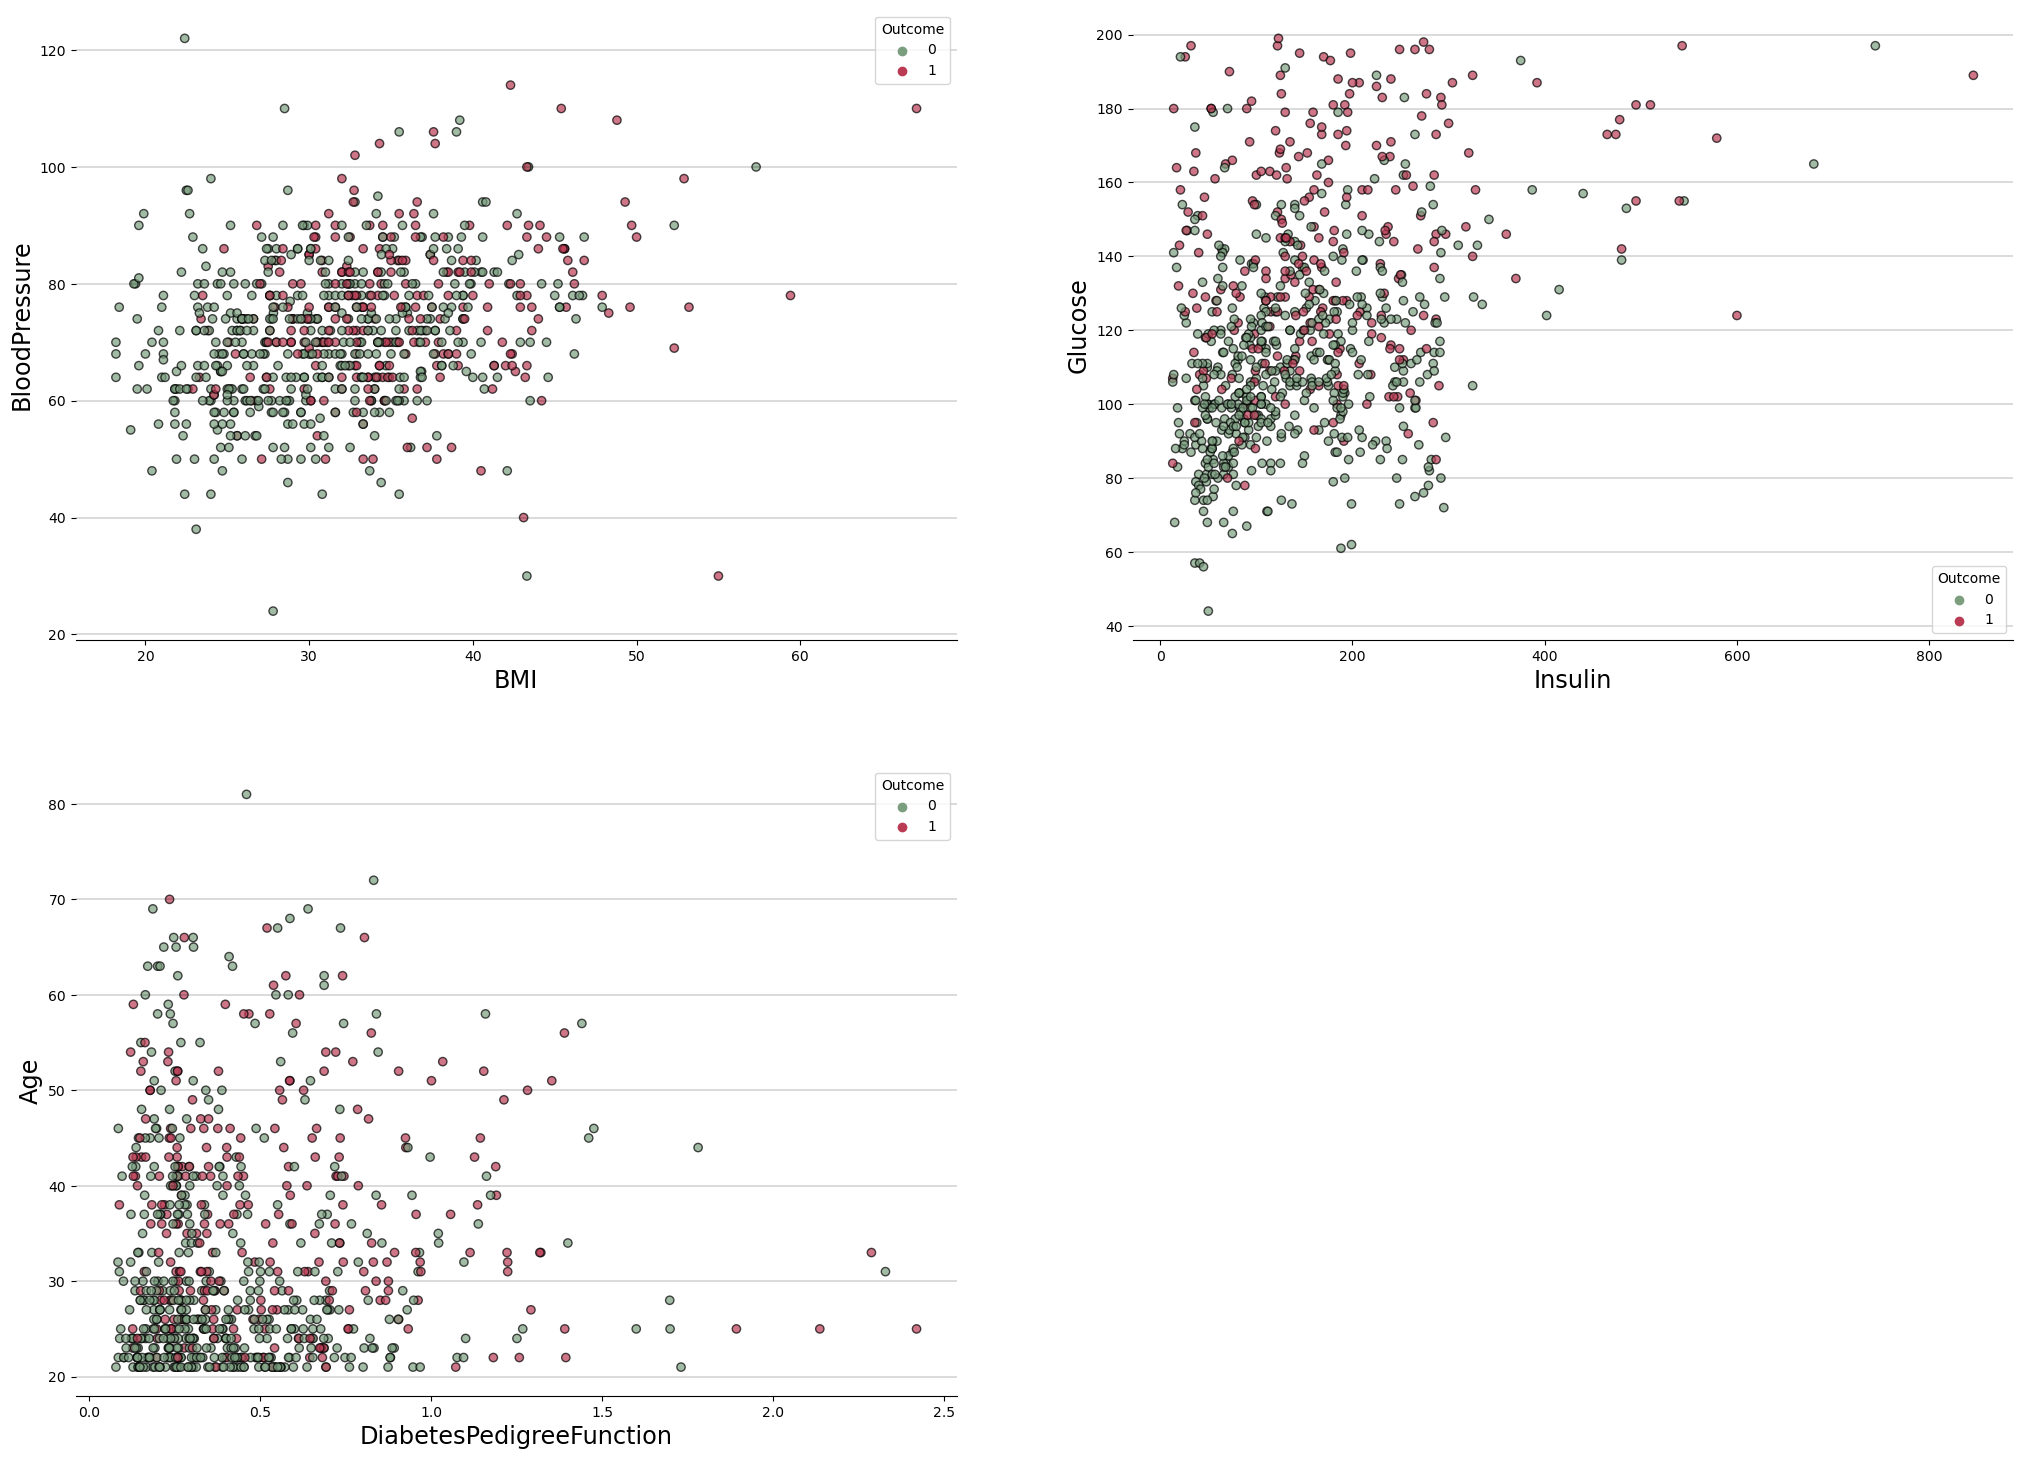

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(25, 18))

scatter(df, "BMI", "BloodPressure", axs[0][0], hue="Outcome", hue_colors=hue_dict)
scatter(df, "Insulin", "Glucose", axs[0][1], hue="Outcome", hue_colors=hue_dict)
scatter(df, "DiabetesPedigreeFunction", "Age", axs[1][0], hue="Outcome", hue_colors=hue_dict)

fig.delaxes(axs[1][1])

plt.show()

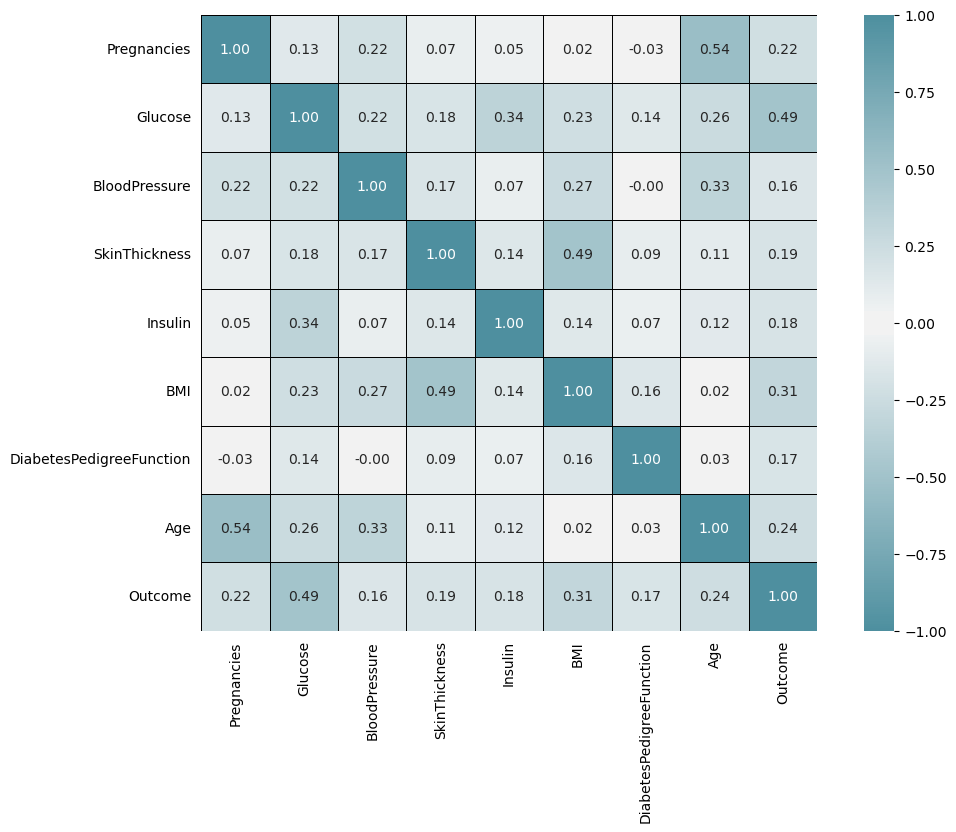

In [13]:
palette = sns.diverging_palette(214, 214, s=70, l=56, as_cmap=True, sep=10)

fig, ax = plt.subplots(figsize=(12, 8))

correlation_matrix(df, ax, palette=palette)

plt.show()

<p style="font-size:1.2em">With a value of 0.49, the highest correlation with "Outcome" is with "Glucose."<br><br> After exploring the data in depth and understood how they behave. The next step is to look for a model that can make reliable predictions on the dataset.</p>

<div style="background-color:#00FFFF; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:blue">Modelling</a></h2>
</div>

<p style="font-size:1.2em"><b>Data Preparation</b></p>

In [14]:
SEED = 23

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED, 
    stratify=y, shuffle=True)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

<div style="background-color:#9FD4E5; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:#000000"><a>Searching for a baseline model</a>
</h2>
</div>

<p style="font-size:1.4em"> 1. <code>LogisticRegression</code></p>

In [15]:
lr = LogisticRegression()

cv_and_evaluate(lr, X_train_scaled, y_train, X_test_scaled, y_test, name="LogisticRegression")

LogisticRegression CV Results 	 Mean: 0.7569444444444444 	 Std: 0.020833333333333332
[0.72222222 0.76388889 0.76388889 0.77777778]
Test scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.78         0.77      0.54        0.63         0.84
==========  ===========  ========  ==========  ===========


<p style="font-size:1.4em"> 2. <code>Support Vector Classifier (SVC)</code></p>

In [16]:
svc = SVC(probability=True, random_state=SEED)

cv_and_evaluate(svc, X_train_scaled, y_train, X_test_scaled, y_test, name="SVC")

SVC CV Results 	 Mean: 0.7743055555555556 	 Std: 0.024305555555555542
[0.73611111 0.79861111 0.77083333 0.79166667]
Test scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.73         0.63      0.57         0.6         0.78
==========  ===========  ========  ==========  ===========


<p style="font-size:1.2em">The results of both models are very similar.<br>SVC is chosen as the model to proceed for tuning. In fact, support vector machines allow good tuning, and having little data they perform very well, both in time factor and metrics</p>

<p style="font-size:1.2em">In fact, having to diagnose a disease, it is more important for our model to have a higher <b>recall</b> score, even at the cost of giving up some precision.</p>

<div style="background-color:#9FD4E5; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:#000000"><a>Hyperparameters Tuning</a>
</h2>
</div>

In [17]:
model = SVC(probability=True, random_state=SEED)

params_grid = {
    "gamma": [0.1, 1, 10, 100],
    "C": [0.1, 1, 10, 100, 1000]
}

svc_gridsearch = GridSearchCV(model, params_grid, n_jobs=-1)

svc_gridsearch.fit(X_train_scaled, y_train)

GridSearchCV(estimator=SVC(probability=True, random_state=23), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.1, 1, 10, 100]})

In [18]:
print("Best params: \t", svc_gridsearch.best_params_)
print("Best Score: \t", svc_gridsearch.best_score_)

Best params: 	 {'C': 1, 'gamma': 0.1}
Best Score: 	 0.7622488755622189


In [19]:
model = svc_gridsearch.best_estimator_

cv_and_evaluate(model, X_train_scaled, y_train, X_test_scaled, y_test, name="SVC tuned")

SVC tuned CV Results 	 Mean: 0.7743055555555556 	 Std: 0.0232923747656228
[0.73611111 0.77777778 0.78472222 0.79861111]
Test scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.74         0.65      0.58        0.61         0.79
==========  ===========  ========  ==========  ===========


<p style="font-size:1.2em">Despite the tuning of hyperparameters, the <u>model has not improved much</u>. Therefore, I will try <b>oversampling</b> the minority class using <code>SMOTE()</code> function of the <code>imblearn</code> library. In this way, I hope to be able to increase the recall of the model.</p>

In [20]:
smote = SMOTE(random_state=SEED)

X_train_over, y_train_over = smote.fit_resample(X_train_scaled, y_train)

cv_and_evaluate(model, X_train_over, y_train_over, X_test_scaled, y_test, name="SVC Tuned with Oversampling")

SVC Tuned with Oversampling CV Results 	 Mean: 0.7987470133120947 	 Std: 0.03224962783211168
[0.76595745 0.7712766  0.84491979 0.81283422]
Test scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.71         0.57      0.72        0.64          0.8
==========  ===========  ========  ==========  ===========


<div style="background-color:#9FD4E5; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:#000000">Feature Importances<a>
</h2>
</div>

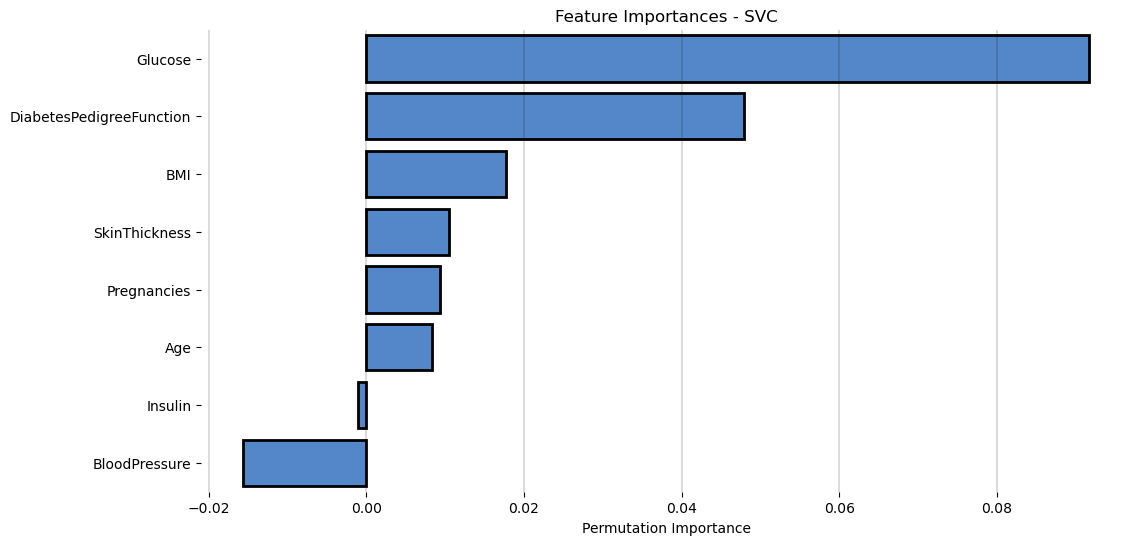

In [21]:
from sklearn.inspection import permutation_importance

importances = pd.Series(permutation_importance(model, X_test_scaled, y_test, random_state=SEED).importances_mean, 
                        index=X_test.columns)
importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(x=importances.values, y=importances.index, ax=ax, color=color, linewidth=2, edgecolor="black")

ax.set_xlabel("Permutation Importance")
ax.set_title("Feature Importances - SVC")
set_style(ax, axis_grid="x", bottom=True)

plt.show()

<p style="font-size:1.2em">The most important feature, as predicted during the EDA is "<b>Glucose</b>". It is followed, surprisingly, by "DiabetesPedigreeFunction," which is the second most important. <br> Note that with these data, the columns "Insulin" and "BloodPressure" have a <b>negative value</b>. This means that the model performs better without them. Let's try removing them and see what happens.</p>

In [22]:
X_train_over = np.delete(X_train_over, [2, 4], axis=1)
X_test_scaled = np.delete(X_test_scaled, [2, 4], axis=1)

cv_and_evaluate(model, X_train_over, y_train_over, X_test_scaled, y_test, name="SVC - Feature Selection")

SVC - Feature Selection CV Results 	 Mean: 0.7880447149846399 	 Std: 0.027753963054182013
[0.7606383  0.78191489 0.8342246  0.77540107]
Test scores
==========  ===========  ========  ==========  ===========
  Accuracy    Precision    Recall    F1 Score    Auc Score
==========  ===========  ========  ==========  ===========
      0.71         0.57      0.76        0.65         0.81
==========  ===========  ========  ==========  ===========


<p style="font-size:1.2em">The value for recall has increased again with this selection</p>

<div style="background-color:#9FD4E5; padding:2em; border:solid; border-width:0.3em; border-radius:0.5em; border-color:#342E37">
    <h2 style="text-align:center; color:#000000"><a>Conclusion</a>
</h2>
</div>

<p style="font-size:1.2em">In this notebook, an in-depth data exploration is carried out and making the best use of data visualization. <br>
The data is cleaned by replacing null values with more probable ones, without losing any training instances. <br>
Later, after finding a promising model, we optimized it. To achieve even better performance, we finally oversampled the minority class, and selected the best features. <br><br>
The results are not the best possible, and this is due to the small amount of data available. By having more training instances available most likely our model could have had much better results.In that case we could also train a more powerful model such as XGBoosts.<p>